# QSite 2024 - Classiq Open Challenge Solution - DRAFT

*Submitted by: Yevgeny Menaker, team: Quantotto*

The work is tracked in the following GitHub repository:
https://github.com/quantotto/Q-SITE-Classiq-Open-Challenge

$\newcommand{\bra}[1]{\langle #1|}$
$\newcommand{\ket}[1]{|#1\rangle}$

In this challenge, we will be solving a differential equation using Quantum Computing algorithm and implementing on the Classiq platform. The work focuses on the scientific paper titled "[A Quantum Algorithm for Solving Linear Differential Equations: Theory and Experiment](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.101.032307)", presented by Tao Xin, et al. in 2020.

We are given the following second order Linear Differential Equation (LDE) representing a harmonic oscillator:

$y'' + {\omega}y = 0$,  $y(0) = 1$,  $y'(0) = 1$

We should solve it using the Quantum Algorithm from the above mentioned paper for the case of ${\omega}=1$ and use the solution to evaluate the kinetic and potential energies in the time interval of $(0, 1)$. We will also study how the energies vary when we use different boundary conditions for $y(0), y'(0)$. Finally, we will leverage the Classiq platform to optimize our quantum circuits for width and depth.

This work is organized in four parts.

Part I shows analytical solution for the above equation. Having precise solution will serve as a reference for our quantum algorithm and will allow estimating the accuracy of the produced results.

Part II formulates the problem in the matrix form and present a simplified version of quantum algorithm solving the equation.

Part III is the heart of this work, where we are solving the LDE using the Taylor series expansion. We create a Quantum model on Classiq platform implementing the approach from the scientific paper. We analyze the accuracy of the algorithm compared to the analytical solution for different orders of approximation. Then, we calculate the energies for various boundary conditions.

Part IV concludes this work with optimization of Quantum Circuit for depth and width with help of the Classiq tools.

<div style="page-break-after: always;"></div>

## Part I - Analytical Solution

Given the conditon of ${\omega}=1$ we are solving the following second order LDE:

$y'' + y = 0$

There are multiple ways to obtain the closed solution for $y(t)$. Let's use the method of characteristic polynomial. For this equation we are obtaining the following quadratic polynomial:

$r^2 + 1 = 0$

It is easy to see that the solutions of this equation are two complex numbers: $r={\pm}i$. For the case of two complex roots of characteristic polynomial, the general solution of the differntial equation is linear combination of trigonometric functions:

$y(t) = {C_1 \cdot cos(t)} + {C_2 \cdot sin(t)}$

Solving for $C_1$ and $C_2$ with boundary conditions of $y(0) = 1$,  $y'(0) = 1$, we obtain:

$y(t) = cos(t) + sin(t)$

For more general case of boundary conditions $y(0) = a, y'(0) = b$ the solution takes the following form:

$y(t) = a \cdot cos(t) + b \cdot sin(t)$

For calculation of energy of harmonic oscillation we will need the $k$ and $m$ values for spring coefficient and mass respectively. Since $\omega=1$ we can conclude that $k=m=1$ because $\omega$ is given by $\omega=\sqrt{\frac {k}{m}}=1$ which trivially leads to $k=m=1$.

The formulas for energy calculation that we will use in the next parts are:

Potential energy: $U = \frac{k \cdot y^2}{2} = \frac{y^2}{2} = \frac{{y(t)}^2}{2}$

Kinetic energy: $K = \frac{m \cdot v^2}{2} = \frac{v^2}{2} = \frac{{y'(t)}^2}{2}$

where $v$ is the velocity and it is given by first derivative of y(t).

<div style="page-break-after: always;"></div>

## Part II - Linear Differential Equation - Matrix Form

In order to solve a differential equation on Quantum Computer, we need to formulate it in the language it naturally understands. Hence, we have to switch to Linear Algebra. LDEs can be formulated as a system of linear equations:

$\frac{d}{dt}y = M \cdot y + b$

Where $y$ is N-dimensional vector, $M$ is $N \times N$ matrix. N is the order of differential equation. Hence, $N=2$ in our case.

After re-writing the given LDE as $y'' = -y$, our second order differential equation can be represented in a matrix form and using the vectors with up to first degree derivatives:

$\frac{d}{dt}\begin{pmatrix}
  y \\
  y'
\end{pmatrix} = \begin{pmatrix}
  0 & 1\\
  -1 & 0
\end{pmatrix}\cdot \begin{pmatrix}
  y \\
  y'
\end{pmatrix}$

>NOTE: Since we don't have any constant terms in the original equation, $b=0$. We will use this fact, when simplifying the quantum circuit.

A well known fact that is used in the scientific paper is that the solution of this differential equation can be obtained through matrix exponentiation:

$y = e^{M \cdot t}$

After careful examination of our $M = \begin{pmatrix}
  0 & 1\\
  -1 & 0
\end{pmatrix}$, we notice that it is actually Pauli-Y up to $-i$ factor. So, the solution takes the following form:

$y = e^{-iY \cdot t}$

Pauli exponentiation can be effectively realized on Quantum Computer with single qubit gate. We can simply use the RY operation. To remind, RY is dependent on the angle $\theta$ and represented by the $2 \times 2$ matrix:

$RY(\theta) = \begin{pmatrix}
  cos(\frac{\theta}{2}) & -sin(\frac{\theta}{2})\\
  -sin(\frac{\theta}{2}) & cos(\frac{\theta}{2})
\end{pmatrix}$

From this:

$e^{-iY \cdot t} = RY(2t) = \begin{pmatrix}
  cos(t) & -sin(t)\\
  -sin(t) & cos(t)
\end{pmatrix}$

So, if we evolve the $\ket {y_0}$ vector representing the boundary conditions, we should obtain the solution.

$\ket {y_0} = \frac{1}{\sqrt 2} \begin{pmatrix}
  1 \\
  1
\end{pmatrix}$

Note that we applied the normalization factor of $\frac{1}{\sqrt 2}$ for $\ket {y_0}$.

We can easily implement this calculation as a quantum program to obtain the desired solution up to the normalization factor (norm of $\ket {y_0}$).

$RY(2t)\ket {y_0} = \frac{1}{\sqrt 2}\begin{pmatrix}
  cos(t) & -sin(t)\\
  -sin(t) & cos(t)
\end{pmatrix}\begin{pmatrix}
  1 \\
  1
\end{pmatrix} = \frac{1}{\sqrt 2}\begin{pmatrix}
  cos(t)-sin(t)\\
  sin(t)+cos(t)
\end{pmatrix}$

Multiplying by the norm of $\ket {y_0}$ ($\sqrt 2$), we retrieve the solution that we derived in Part I.

Building this Quantum Model is farly easy on the Classiq platform:
- We prepare qubit phi in the $\ket +$ state
- We apply RY with $\theta = 2t$

```python
from classiq import *
import numpy as np

t = 2 * np.pi / 3
@qfunc
def main(phi: Output[QBit]):
    allocate(1, phi)
    H(phi)
    RY(2*t, phi)
```

We can then create, synthesize and test the model using State Vector simulator. It shows that the results of quantum simulation agree with the analytical solution.

```python
from classiq.execution import (
    ClassiqBackendPreferences,
    ClassiqSimulatorBackendNames,
    ExecutionPreferences,
)
backend_preferences = ClassiqBackendPreferences(
    backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
)
quantum_model = create_model(main,
    execution_preferences=ExecutionPreferences(
        num_shots=1024, backend_preferences=backend_preferences
    )
)
quantum_program = synthesize(quantum_model)
res = execute(quantum_program)
analytical = np.cos(t) + np.sin(t)
amps = np.array([ps.amplitude for ps in res.result()[0].value.parsed_state_vector]) * np.linalg.norm([1.0, 1.0])
print(f"Analytical={analytical}; Quantum amps={amps}")
print(complex(res.result()[0].value.state_vector["1"]) * np.linalg.norm([1.0, 1.0]))
```

Output:
```
Analytical=0.36602540378443893; Quantum amps=[-1.3660254+0.j  0.3660254+0.j]
(0.36602540378443965+0j)
```

With this preliminary background out of the way, we are now going to apply the approach from the scientific paper to solve this differential equation. We will use the Matrix form developed in this part.

<div style="page-break-after: always;"></div>

## Part III - Quantum Algorithm from scientific paper

The paper suggests solving the differential equation using the Taylor series expansion up to the desired order of approximation. Higher orders require more qubits. According to the algorithm, we have the following qubits allocations:
- 1 ancilla qubit (we will not need this qubit in our implementation; see _Operator V_ subsection below)
- $\log_2(k+1)$ approximator qubits, where $k$ is order of approximation
- 1 qubit for $\ket {\phi}$ (work qubit) which encodes both $\ket {y_0}$ and $b$ (in our case $b=0$)

Our goal is to implement the quantum circuit presented in the paper. See Figure below taken from the paper.

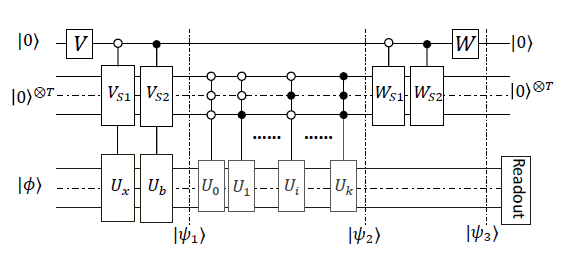

All qubits start in the $\ket 0$ state.

We will now derive all the operators required for solving our differential equation. It is worth emphasizing that, in a way, the suggested algorithm is implementing Linear Combination of Unitaries, where we use Taylor expansion to produce the coefficients and the unitaries are powers of matrix A (derived from matrix M - see previous section for the matrix form of differential equation)

### Operator Um

The $U_m$ operator is simply $A^m$ where A is unitary derived from M in the matrix form of differential equation. The paper instruct to calculate $A$ from $M$:

$A = \frac {M}{||M||}$

Then, there are two cases for when A unitary and non-unitary. It should be added that a third case should be considered, when M is unitary as it happens to be in our case. For $M = \begin{pmatrix}
  0 & 1\\
  -1 & 0
\end{pmatrix}$, the norm $||M||=\sqrt 2$. Hence, dividing by it produced non-unitary. However, it is actually a unitary up to the normalization factor, which is $||M||$. From this, in the implementation, we assume $A = M$. This also leads to modification in calculating the $C_m$ values. Wherever $||M||$ is used, we replace it with 1.

### Operator V

V on ancilla puts it into a superposition and is used as a control qubit to encode $y_0$ and $b$. Since $b$ is zero in our case, we actually only need to encode $y_0$. V ends up being Z operator, which effectively leaves the $\ket 0$ state intact on ancilla. It basically removes the need for ancilla and operator $V$.

### Operator Vs1

Vs1 on the approximator qubits encode Taylor coefficients that control the operations on the $y_0$ part of of superposition. The number of coefficients depend on the order of approximation. As mentioned above under the Operator Um, we substitute $||M||$ with 1. It was also discovered that we should substitute the $||x_0||$ (or in our notation $||y_0||$) with 1 and just apply this as normalization factor to the solution we obtain from the algorithm execution. The function for calculating vector of $C_m$ values is shown below.

```python
def calculate_Cs(t, k):
    arr = [((t) ** i) / math.factorial(i) for i in range(k+1)]
    return arr
```

Moreover, in the paper, it is stated that we need to populate the first row with the normalized square roots of coefficients from Taylor expansion ($\sqrt{C_0}, \sqrt{C_1}, ..., \sqrt{C_k}$). It should actually be first column as indicated in the supplemental material of the scientific paper.

The work of generating the Vs1 unitary is performed by the `create_unitary` function. It will generate a unitary matrix based on the given first column. We apply the Gram-Schmidt orthogonolization to fill out the remaining columns. See its implementation in the Appendix A of this work. 

### Operator Vs2

We can skip the definition of Vs2 because it is only needed in case of non-zero b. Since we do not need to create a super-position of Vs1 with Vs2, the Vs1 operator will be applied without the control qubit. As noted above, we are removing the ancilla qubit to optimize our circuit for width.



### Coding with Classiq

Classiq allows simplifying the implementation using the following powerful statements:

- `control` to implement multi-qubit control operations (e.g. we need them to apply operators $U_m$ controlled by approximator qubits)
- `within_apply` to implement the $V^\dagger U V$ template (in this case, we need to apply the inverse of Vs1 after the series of controlled $U_m$ operations)
- `repeat` to loop through multiple $U_m$ operators
- `power` to implement $U_m = A^m$

Below is our model implementation. There are some helper functions used. In order to not clutter the code of the model, some helper functions are moved to Appendix A.

The algorithm has four main steps:
- Encode qubits (quantum)
- Approximate (quantum)
- Decode (quantum)
- Post-processing (classical)

During post-processing, we post-select the work qubits ($\ket {\phi}$) values for the sub-space of ancilla and approximator qubits in the $\ket 0$ states.

We split the work of quantum part into three qfuncs:

- `encode` applies initial operator V on ancilla and calls `prep_qubits` controlling on value 0 of the ancilla
- `prep_qubits` applies Vs1 unitary
- `approximate` prepares the phi qubit in `y_0` state and repetedly applies the $U_m$ operators

```python
@qfunc
def prep_qubits(Vs1: CArray[CArray[CReal]], approximator: QArray):
    unitary(Vs1, approximator)

@qfunc
def encode(Vs1: CArray[CArray[CReal]], approximator: QArray):
    prep_qubits(Vs1, approximator)

@qfunc
def approximate(A: CArray[CArray[CReal]], normalized_y0: CArray[CReal], approximator: QNum, phi: QBit):
    inplace_prepare_amplitudes(normalized_y0, bound=0.01, target=phi)
    repeat(2 ** approximator.size, lambda i: control(approximator==i, lambda: power(i, lambda: unitary(A, phi))))
```

We decalre a few input parameters.

```python
# inputs for y'' + y = 0
y0 = [1.0, 1.0]          # Boundary conditions
A = [[0, 1], [-1, 0]]    # Linear equations (unitary)
k = 7                    # order of approximation
t = np.pi / 3
def total_qubits():
    global k
    return int(np.log2(k+1)) + 1
Cs = calculate_Cs(t, k)
V = calculate_V()
Vs1 = calculate_Vs1(Cs)
normalized_y0 = normalize(y0)
```



The work is controlled from the `main` function of the model, which uses the `within_apply` to drive the entire implementation.

```python
@qfunc
def main(
    phi: Output[QBit],
    approximator: Output[QNum],
):
    allocate(1, phi)
    allocate(int(np.log2(k+1)), approximator)
    within_apply(
        within=lambda: encode(Vs1, approximator),
        apply=lambda: approximate(A, normalized_y0, approximator, phi)
    )
```

### Post-processing

After model execution, we select the results of $\ket {\phi}$ qubit measurements in the subspace of ancilla and approximator qubits in state $\ket 0$. We then normalize the amplitudes to assure that total probability of post-selected states is equal to 1. We finally extract the solution by calculating the amplitudes of states $\ket 0$ and $\ket 1$ and appying the normalization factor ($||y_0||$). Amplitude of state $\ket 0$ determines the position $y(t)$ and amplitude of state $\ket 1$ determines velocity $y'(t)$.

The `solve` function puts it all together and solves the differential equation for a given `t`.

```python
def solve(t) -> tuple[float, float]:
    # solve differential equation using quantum algorithn
    # and return a tuple of position and velocity at time t

    # Calculate model parameters
    global Cs, V, Vs1, normalized_y0
    Cs = calculate_Cs(t, k)
    V = calculate_V()
    Vs1 = calculate_Vs1(Cs)
    normalized_y0 = normalize(y0)

    # Create, synthesize and execute the model
    quantum_model = create_model(main,
        execution_preferences=ExecutionPreferences(
            num_shots=1024, backend_preferences=backend_preferences
        )
    )
    quantum_program = synthesize(quantum_model)
    res = execute(quantum_program)

    # post-select results with ancilla and approximator qubits equal to 0
    amps = [
        ps.amplitude for ps in res.result()[0].value.parsed_state_vector
        if ps["approximator"] == 0
    ]
    # Re-scale amplitudes
    total_prob = (amps[0] * amps[0].conjugate() + amps[1] * amps[1].conjugate())
    
    # Extract position and velocity (position is the y(t) and velocity y'(t))
    # Position is amplitude of phi=0 and velocity is amplitude of phi=1
    Y_key, V_key = state_vector_keys(total_qubits())
    Y_amp = complex(res.result()[0].value.state_vector[Y_key]) / np.sqrt(total_prob)
    V_amp = complex(res.result()[0].value.state_vector[V_key]) / np.sqrt(total_prob)

    # Calculate real values and rescale the values by norm of y0
    Yt = np.sqrt((Y_amp * Y_amp.conjugate()).real) * norm(y0)
    Vt = np.sqrt((V_amp * V_amp.conjugate()).real) * norm(y0)
    return (Yt, Vt)
```

### Accuracy

We can now use our solution to study the accuracy of quantum algorithm per order of approximation. We will use $k = 1, 3, 7$ as three orders of approximation and plot quantum and classical solutions alongside to demonstrate that accuracy increases with higer orders of approximation. We run the algorithm for 10 points in the interval $(0, \pi)$.

Figure below shows a classical (analytical) solution along with quantum ones for different orders of approximation.

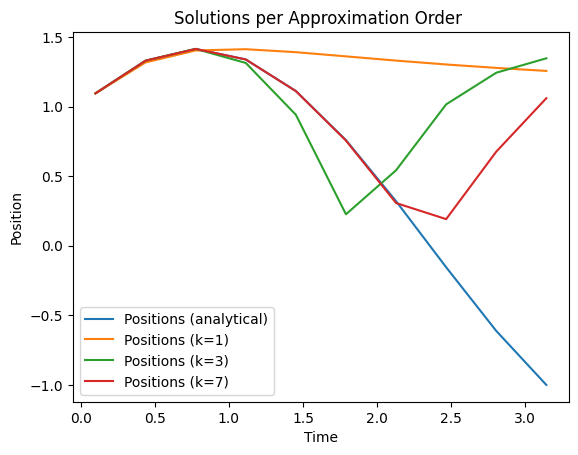

At all orders, we are getting fairly accurate results in the $(0, 1)$ interval. With k=7, the classical and quantum solutions are practically identical. Quantum solution starts to diverge from classical when the position values turn negative. In fact, this is indeed a limitation of current implementation: no option to produce negative results. Overcoming this limitation is left to future works on this subject.

We conclude that we can safely use $k=3$ or $k=7$ to estimate the solutioon in the $(0, 1)$ interval.

### Calculating Energies

We calculate the Kinetic and Potential energies using the formulas that we presented in Part I.

Potential energy: $U = \frac{k \cdot x^2}{2} = \frac{x^2}{2} = \frac{{y(t)}^2}{2}$

Kinetic energy: $K = \frac{m \cdot v^2}{2} = \frac{v^2}{2} = \frac{{y'(t)}^2}{2}$

This is fairly trivial task after obtaining the results of the `solve` function:

```python
def calculate_energies(t) -> tuple[float, float]:
    # Calculate kinetic and potential energy at time t

    Yt, Vt = solve(t)
    return (Vt ** 2) / 2, (Yt ** 2) / 2
```

Executing the quantum model for different values of boundary conditions ($y_0$) produced the results that agree with the classical (analytical) solution. See figures below for Kinetic and Potential energies for two choices of $y_0$: (1.0, 1.0) and (1.0, 5.0) with order of approximation $k=3$.

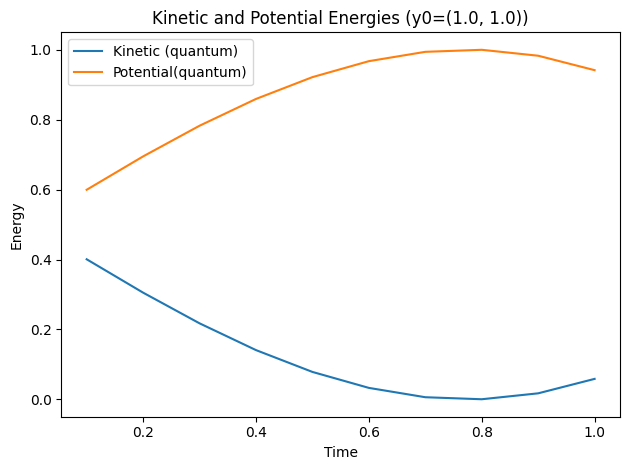
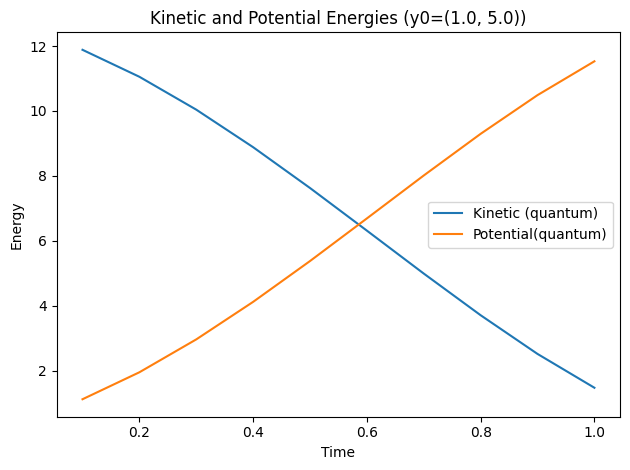

<div style="page-break-after: always;"></div>

## Part IV - Quantum Circuit Analysis and Optimizations

Following the work of creating and executing the quantum circuit, we will now turn to analyzing its depth and width and see if there any ways to optimize them.

We will select the $k=3$ as our order of approximation. We used it to generate all of the above results. Boundary condition will be $(1.0, 1.0)$. With that, we generate the model using the default settings and evaluate the width and depth.

Then, we will apply optimizations and observe the results.

Note that in the course of adapting the algorithm for our case of a concrete differential equation $y'' + y = 0$, we already applied a few optimizations:
- Removes the ancilla qubit, because we don't need to create a super-position of $y_0$ and $b$ due to $b=0$
- Removed operators V and Vs2
- Applying Ux and Vs1 without the controls
- Selected intermediate order of optimization ($k=3$) further reducing the number of required approximator qubits

Without applying any additional constraints, we are actually getting fairly shallow circuits. As expected, higher order of approximation leads to larger depth.

```
Circuit with default parameters and k=3
    width=3
    depth=83
Circuit with default parameters and k=7
    width=4
    depth=413
```

Attempting to optimize further doesn't produce more shallow output:
```
Could not find a solution that satisfies the constraints: Couldn't generate a circuit with satisfactory depth.
Minimal value found: 442
```

Basically, all the optimization work that was done during the algorithm development paid off. As a side experiment, adding ancilla qubit and controlled operations based on it, resulted in depth of 1012 for k=7. We were able to reduce the depth by more than 2x with the removal of ancilla.

# References

1. Tao Xin, et al. 2020 "A Quantum Algorithm for Solving Linear Differential Equations: Theory and Experiment"
2. Steve Brunton, "The Simplest Ordinary Differential Equation (ODE) and Its Exponential Solution", https://www.youtube.com/watch?v=BjvkBLfvkqY
3. https://www.mycompiler.io/view/Di9dsPfR4gy, "Gram-Schmidt Orthogonalization" code snippet

# Appendix A - Helper Functions

Generic linear algebra helpers.

```python

def analytical_solution(boundary_condition, x):
    return boundary_condition[0] * np.cos(x) + boundary_condition[1] * np.sin(x)

def norm(a):
    return np.linalg.norm(a)

def normalize(a):
    return list(np.array(a) / norm(a))

def sqrt_sum(a):
    return np.sqrt(np.sum(np.array(a)))

def create_unitary(first_column):
    # Create unitary given first column
    #
    k = len(first_column)
    added_rows = []
    for i in range(k-1):
        row = [0] * k
        row[i] = 1
        added_rows.append(row)
    A = np.array([
        normalize(first_column),
        *added_rows
    ]).T
    n = A.shape[1]
    # Use Gram-Schmidt orthogonalization
    # Credits: https://www.mycompiler.io/view/Di9dsPfR4gy
    for i in range(1, n):
        for j in range(i):
            A[:, i] = A[:, i] - np.dot(A[:, j], A[:, i]) * A[:, j]
            A[:, i] = A[:, i] / np.linalg.norm(A[:, i])
    return A.tolist()
```